In [76]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

from __future__ import absolute_import, print_function
import pyopencl as cl
import numpy as np
import numpy.linalg as la
from time import time
import matplotlib.pyplot as plt
%pylab inline 

VERBOSE = True
MY_PLATFORM = "AMD" # AMD, Intel, Experimental
MY_DEVICE = "GPU" # CPU, GPU, DEFAULT, ACCELERATOR 
MY_DEVICE_NUM = 0 # if multiple device types, i.e. multiple GPUs

# Print version information
print('PyOpenCL version: ' + cl.VERSION_TEXT)
print('OpenCL header version: ' + '.'.join(map(str, cl.get_cl_header_version())) + '\n')
print("Numpy version: {0}".format(np.__version__))
print("MatPlotLib version: {0}".format(matplotlib.__version__))

%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime

Populating the interactive namespace from numpy and matplotlib
PyOpenCL version: 2016.1
OpenCL header version: 1.2

Numpy version: 1.11.0
MatPlotLib version: 1.4.3
Installed autotime.py. To use it, type:
  %load_ext autotime
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.15 s


`%matplotlib` prevents importing * from pylab and numpy


In [77]:
# choose a platform:
def choose_platform(plat_choice):
    my_platform = None
    plat = cl.get_platforms()
    try:
        for i in range(len(plat)):
            if (plat_choice.upper() in str(plat[i].name).upper()):
                my_plat = plat[i]    
        if (VERBOSE):
            if (my_plat == None):
                print (plat_choice, "platform not found!")
            else:
                print ("Platform Selected:", my_plat.name)
    except:
         print ("Exception: Failed to get platform:",plat_choice)
    return my_plat

# choose a device
def choose_device(platform_choice,device_choice,device_num):
    my_device = None
    if (device_choice.upper() == "CPU"):
        my_device = platform_choice.get_devices(cl.device_type.CPU)      
    elif (device_choice.upper() == "GPU"):
        my_device = platform_choice.get_devices(cl.device_type.GPU)
    elif (device_choice.upper() == "ACCELERATOR"):
        my_device = platform_choice.get_devices(cl.device_type.ACCELERATOR)
    elif (device_choice.upper() == "DEFAULT"):
        my_device = platform_choice.get_devices(cl.device_type.DEFAULT)
        
    if (VERBOSE >=1): print ("Device Selected: %s (%s)" % (my_device[device_num].name,device_choice.upper()))
    
    return my_device[device_num],

# setup pyopencl with platform, device, context, and queue
def setup_pyopencl(platform_choice,device_choice,device_num):
    try:
        platform = choose_platform(platform_choice)
        device = choose_device(platform, device_choice,device_num)
        context = cl.Context(device)
        queue = cl.CommandQueue(context,properties=cl.command_queue_properties.PROFILING_ENABLE)    
        return platform, device, context, queue
    except:
        print ("Unable to set up pyopencl. Please try a different platform/device.")
        print ("Make sure you have the correct platform selected.")
        return None, None, None, None

time: 60 ms


In [78]:
# non opencl matrix multiply function    
def regular_matrix_multiply(a,b):
    return np.mat(a)*np.mat(b)

# pyopencl matrix multiply function:
def pyopencl_matrix_multiply(matrix_a, matrix_b,my_plat,my_dev,my_dev_num):
    # OpenCL routines and objects
    plat, dev, ctx, queue = setup_pyopencl(my_plat,my_dev,my_dev_num)
    
    if (VERBOSE >=2):
        print ("Platform:",plat)
        print ("Device:",dev)
        print ("Context:",ctx)
        print ("Queue:",queue)
        
    
    # OpenCL kernel code    
    kernel_code = """
            __kernel void krnl_matmul(const unsigned int size,
                                      __global const float * matrix_a,
                                      __global const float * matrix_b, 
                                      __global float * matrix_c) 
            {
              int i = get_global_id(0);
              int j = get_global_id(1);
              float tmp = 0;
              for (int k=0; k<size; ++k) {
               tmp += matrix_a[i*size+k] * matrix_b[k*size + j];
              }
              matrix_c[i*size+j] = tmp;
            }
    """
    prg = cl.Program(ctx,kernel_code).build()
    t0 = time()#t0 = datetime.datetime.now()

    # transfer from host to device
    mf = cl.mem_flags
    a_buf = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=matrix_a)
    b_buf = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=matrix_b)
    dest_buf = cl.Buffer(ctx, mf.WRITE_ONLY, matrix_a.nbytes )
    t1 = time()
    
    prg.krnl_matmul(queue, matrix_a.shape, None, np.int32(len(matrix_a)) ,a_buf, b_buf, dest_buf)
    
    final_matrix = np.empty_like(matrix_a)
    t2 = time()
    
    # transfer from device back to host
    cl.enqueue_copy(queue, final_matrix , dest_buf).wait()
    t3 = time()
    
    htd_time = t1 - t0 # host to device time
    ocl_time = t2 - t1 # opencl time
    dth_time = t3 - t2 # device to host time

    if (VERBOSE >=2):
        print ('OpenCL transfer to device: ' + str(htd_time))
        print ('OpenCL Multiplication: ' + str(t2 - t1))
        print ('OpenCL transfer back to host: ' + str(t3-t2))
    
    return final_matrix,htd_time,ocl_time,dth_time


time: 90 ms


In [79]:
def run_bench(plat, dev, dev_num=0, m_size=10, mlow=0.0 ,mhigh=1.0):

    t0 = time()
    a = np.random.uniform(low=mlow, high=mhigh, size=(m_size,m_size)).astype(np.float32)
    b = np.random.uniform(low=mlow, high=mhigh, size=(m_size,m_size)).astype(np.float32)
    t1 = time()

    x = (regular_matrix_multiply(a,b))
    t2 = time()
    y, htd_time,ocl_time,dth_time = (pyopencl_matrix_multiply(a,b,plat,dev,dev_num))
    t3 = time()
    
    mat_gen_time = t1-t0
    reg_mm_time = t2-t1
    ocl_mm_time = t3-t2    
    
    return x,y,mat_gen_time,reg_mm_time,ocl_mm_time,htd_time,ocl_time,dth_time

time: 28 ms


In [88]:
plats = ["AMD","INTEL","EXPERIMENTAL"]
devs = ["GPU","CPU"]

MY_PLATFORM = "AMD"
MY_DEVICE = "GPU"

# note only AMD has the GPU since I have a Radeon
#test_sizes = [10,100,200,500,1000]
test_sizes = range(10,1510,10)

time_dict = {}
VERBOSE = 1
for test in test_sizes:
    time_list = []
    #x,y,mg_time,mm_time,oclmm_time,htd_time,ocl_time,dth_time = run_bench("AMD","CPU",test,mlow=0.0,mhigh=1.0)
    time_dict[test] = (run_bench(MY_PLATFORM,MY_DEVICE,MY_DEVICE_NUM,test,mlow=0.0,mhigh=1.0))
    VERBOSE = 0

print ("Test matrix sizes:",test_sizes)
#print("Matrix generation time:", time_dict[test_sizes[1]][0][3], "s")
# for key in time_dict:
# time_dict[key][0]=x, 1=y, 2=mg_time, 3=mm_time, 4=oclmm_time, 5=htd_time, 6=ocl_time, 7=dth_time

OCL_time = []
Serial_time = []
mat_size = []

for key in sorted(time_dict):
    Serial_time.append(time_dict[key][3])
    OCL_time.append(time_dict[key][4])
    mat_size.append(key)
    if (VERBOSE >=2):
        print("\nMatrix size:", key)
        print("Matrix generation time:", time_dict[key][2], "s")
        print("Matrix multiply time:", time_dict[key][3], "s")
        print("Total OpenCL MM time:", time_dict[key][4], "s")
        print("Transfer to device time: ", time_dict[key][5], "s")
        print("OpenCL MM kernel time: ", time_dict[key][6], "s")
        print("Transfer back to host time: ", time_dict[key][7], "s")


Platform Selected: AMD Accelerated Parallel Processing
Device Selected: Cayman (GPU)
Test matrix sizes: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1100, 1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200, 1210, 1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1300, 1310, 1320, 1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420, 1430, 1440, 1450, 1460, 1470, 1480, 1490, 1500]
time: 1min 54s


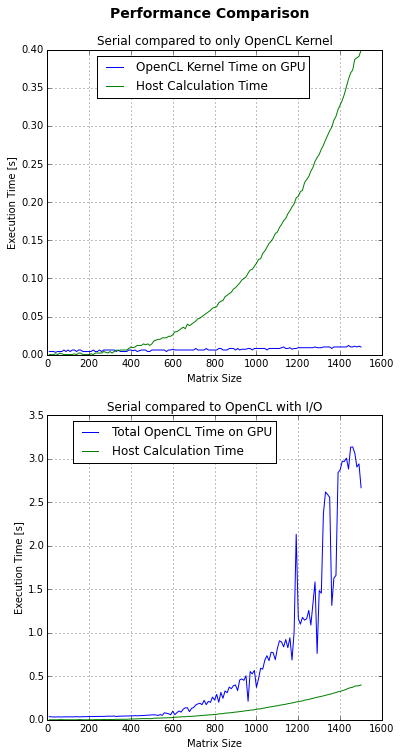

time: 826 ms


In [90]:
OCL_time = []
OCL_kernel_time = []
Serial_time = []
mat_size = []

for key in sorted(time_dict):
    Serial_time.append(time_dict[key][3])
    OCL_time.append(time_dict[key][4])
    OCL_kernel_time.append(time_dict[key][6])
    mat_size.append(key)
    if (VERBOSE >=1):
        print("\nMatrix size:", key)
        print("Matrix generation time:", time_dict[key][2], "s")
        print("Matrix multiply time:", time_dict[key][3], "s")
        print("Total OpenCL MM time:", time_dict[key][4], "s")
        print("Transfer to device time: ", time_dict[key][5], "s")
        print("OpenCL MM kernel time: ", time_dict[key][6], "s")
        print("Transfer back to host time: ", time_dict[key][7], "s")

fig = plt.figure(figsize=(6,12))
fig.suptitle('Performance Comparison', fontsize = 14, fontweight = 'bold', y = 0.95)

plt.subplot(211)
plt.plot(mat_size, OCL_kernel_time, label='OpenCL Kernel Time on '+MY_DEVICE)
plt.plot(mat_size, Serial_time, label='Host Calculation Time')
plt.xlabel('Matrix Size')
plt.ylabel("Execution Time [s]")
plt.title('Serial compared to only OpenCL Kernel')
plt.legend( bbox_to_anchor=(0.8, 1),ncol=1)
plt.grid(True)

plt.subplot(212)
plt.plot(mat_size, OCL_time, label='Total OpenCL Time on '+MY_DEVICE)
plt.plot(mat_size, Serial_time, label='Host Calculation Time')
plt.xlabel('Matrix Size')
plt.ylabel("Execution Time [s]")
plt.title('Serial compared to OpenCL with I/O')
plt.legend( bbox_to_anchor=(0.7, 1),ncol=1)
plt.grid(True)

plt.show()
